<a href="https://colab.research.google.com/github/juli-amezquita/Topic-Modeling-in-Spanish-Amazon-Reviews/blob/main/Topic_Modeling_en_Espa%C3%B1ol_Amazon_Reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyecto - Topic Modeling 

## Dataset: The Multilingual Amazon Reviews Corpus
El Modelado de Temas es tal vez la técnica más utilizada para agrupar y encontrar los denominados temas subyacentes u ocultos en los diferentes textos. El presente proyecto de Topic Modeling tiene justamente como propósito encontrar dichos temas dentro de las reseñas u opiniones dadas por los clientes o usuarios de Amazon y que se encuentran en el dataset que se puede descargar del siguiente [link](https://drive.google.com/uc?export=download&id=11XnXB7Ubgf3t6gotXGlM4FCwPOMHhDLX). 

Para desarrollar lo mencionado anteriormente debe tenerse en cuenta que estamos frente a un problema de aprendizaje no supervisado, esto debido a que nuestros datos no se encuentran etiquetados, es decir, en nuestros datos no se encuentran definidos los temas y por el contrario lo que se hará es encontrarlos. 

Para desarrollar este objetivo se emplearán 3 algorítmos frecuentemente utilizados: Latent Semantic Analysis (LSA), Hierarchical Dirichlet Process (HDP) y Latent Dirichlet Allocation (LDA) y se hará uso de librerías como SpaCy, Gensim, ConTexto y sus dependencias en español. Al final, estos algrorítmos tendrán como resultado grupos de palabras que representan un tema y nuestra labor será interpretarlas para enunciar dichos temas.

El presente proyecto tendrá como contenido los siguientes cinco pasos:

1. Carga de Datos
2. Limpieza y pre-procesamiento de datos
3. Ejecución de Modelos
4. Visualización del Modelo Final y Conclusiones

Si se desea revisar un Análisis Exploratorio de Datos (EDA) y otras aplicaciones sobre este mismo dataset, se puede consultar el siguiente repositorio en [GitHub](https://github.com/juli-amezquita/NLP-Amazon-Reviews-Star-Prediction) o el siguiente link de [nbviewer](https://nbviewer.jupyter.org/github/juli-amezquita/NLP-Amazon-Reviews-Star-Prediction/blob/main/1_NLP%20Amazon%20Reviews%20Espan%CC%83ol.ipynb).

In [1]:
# Este proyecto está desarrollado sobre Google Colab, de esta manera se establce conexión con Google Drive para acceder al dataset 
from google.colab import drive
drive.mount('/content/gdrive')

Antes de iniciar el proceso, se procede a instalar e importar las librerías necesarias para poder llevar a cabo el proyecto.

In [2]:
#! pip install contexto
#! python -m spacy download es_core_news_md
#!pip install pyLDAvis

In [3]:
# Librerías para tratamiento, limpieza y visualización de datos
import numpy as np
import pandas as pd
import re
import string
from unicodedata import normalize
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Librerías para procesamiento de texto y modelado de temas: SpaCy, ConTexto y Gensim
# Para mayor comprensión, en el transcurso del proyecto se irán importando los módulos a utilizar.

## **1. Carga de Datos**

Se cargan los datasets de entrenamiento y de testeo.

In [4]:
data_train = pd.read_json('/content/gdrive/MyDrive/PROYECTO NLP/dataset_es_dev.json', lines= True)
data_train.head()

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
0,es_0417480,product_es_0873923,reviewer_es_0672978,1,"Malisimo, muy grande demasiado aparatoso y mal...",Mala compra,es,wireless
1,es_0180432,product_es_0713146,reviewer_es_0100858,1,No he recibido el pedido no la devolución,No lo he recibido,es,apparel
2,es_0144850,product_es_0356874,reviewer_es_0486447,1,"Tengo que buscar otro sistema, este no funcion...",Que no aprieta bien en el manillar,es,sports
3,es_0339629,product_es_0939832,reviewer_es_0894703,1,Utilicé las brocas de menor diámetro y se me d...,Brocas de mantequilla,es,home_improvement
4,es_0858362,product_es_0489066,reviewer_es_0887663,1,No me gusta su olor a viejo y aspecto malo,No me gusta,es,beauty


In [5]:
data_test = pd.read_json('/content/gdrive/MyDrive/PROYECTO NLP/dataset_es_test.json', lines= True)
data_test.head()

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
0,es_0038754,product_es_0113523,reviewer_es_0580071,1,no me llego el articulo me lo mando por correo...,no me llego,es,wireless
1,es_0748979,product_es_0017036,reviewer_es_0819733,1,"la mensajería horrible, no compro mas",amazon sigue sin cumplir en las entregas,es,home
2,es_0411746,product_es_0138642,reviewer_es_0508607,1,Estoy muy decepcionado con el vendedor ya que ...,ESTAFA EN EL ENVÍO,es,toy
3,es_0786686,product_es_0170887,reviewer_es_0491157,1,Mi valoración no es sobre el producto sino sob...,Estafa de Amazon,es,home
4,es_0429700,product_es_0710642,reviewer_es_0008745,1,Pues tenía interés en este libro y probé la ve...,No conseguí pasar de la portada en Kindle,es,digital_ebook_purchase


In [6]:
# Se revisa la forma del dataframe para saber con cuántos datos contamos
data_train.shape, data_test.shape

((5000, 8), (5000, 8))

Se unifican los dataset de entrenamiento y de testeo.

In [7]:
data = pd.concat([data_train,data_test], ignore_index = True )
data.head()

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
0,es_0417480,product_es_0873923,reviewer_es_0672978,1,"Malisimo, muy grande demasiado aparatoso y mal...",Mala compra,es,wireless
1,es_0180432,product_es_0713146,reviewer_es_0100858,1,No he recibido el pedido no la devolución,No lo he recibido,es,apparel
2,es_0144850,product_es_0356874,reviewer_es_0486447,1,"Tengo que buscar otro sistema, este no funcion...",Que no aprieta bien en el manillar,es,sports
3,es_0339629,product_es_0939832,reviewer_es_0894703,1,Utilicé las brocas de menor diámetro y se me d...,Brocas de mantequilla,es,home_improvement
4,es_0858362,product_es_0489066,reviewer_es_0887663,1,No me gusta su olor a viejo y aspecto malo,No me gusta,es,beauty


In [8]:
# Se revisa la forma del nuevo dataset
data.shape

(10000, 8)

In [9]:
# Se verifica si hay valores faltantes
print(data.isna().sum())

review_id           0
product_id          0
reviewer_id         0
stars               0
review_body         0
review_title        0
language            0
product_category    0
dtype: int64


## **2. Limpieza y pre-procesamiento de datos**


### **Primera función de limpieza:**

Se crea una primera función de limpieza donde se eliminan emoticones, signos de puntuación, dígitos y errores tipográficos.

In [10]:
re_punc = re.compile("([\"\''().,;:/_¿?¡!—\-])") # Agrega espacios alrededor de la puntuación

re_mult_space = re.compile(r"  *") # Reemplaza multiples espacios con solo uno

# Pattern para remover los emoticones. Referencia: https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b
emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)


def clean_text1(text):
    text = re_punc.sub(r" \1 ", text) # Agrega espacios alrededor de la puntuación para corregir por ej: pero,no
    text = re.sub('\w*\d\w*', '', text) # Remueve todos los dígitos
    text = emoji_pattern.sub(r'', text) # Remueve todos los emoticones
    # Remueve todas las puntuaciones incluyendo los signos que no están en la librería string y se convierte texto a minúsculas
    text = re.sub('[%s]' % re.escape(string.punctuation + '¡¿°€ª”'), '', text.lower())
    text = re.sub("(.)\\1{2,}", "\\1", text) # Cuando encuentra 3 letras juntas o más, las remueve y deja solo una. Ej: noooo
    text = re_mult_space.sub(' ', text) # Reemplaza múltiples espacios con solo uno
    return text

In [11]:
# Se toma un ejemplo para probar la función

clean_text1("400€ muyyyyy carooo ✊ 😜 😡 coordinar por 2ª vez, pero,NO   me gusta")

' muy caro coordinar por vez pero no me gusta'

In [12]:
%%time
# Se aplica la función clean_text1 sobre todo el dataset
data['review_body'] = data['review_body'].apply(lambda x: clean_text1(x))

CPU times: user 712 ms, sys: 3.26 ms, total: 716 ms
Wall time: 720 ms


 ### **Se eliminan stopwords**

 De la librería de ConTexto y el módulo de limpieza, se importa la lista de stopwords, se agregan y se eliminan algunas palabras a esta lista.

In [13]:
# Del módulo limpieza de ConTexto se importa el listado de las stopwords
from contexto.limpieza import lista_stopwords

In [14]:
# Se instancia el objeto y se cuentan cuántas palabras contiene la lista
stopwords = lista_stopwords()
print(len(stopwords))

350


**Se remueve de las stopwords la palabra 'no'**

In [15]:
stopwords.remove('no')
len(stopwords)

349

**Se agregan unas palabras adicionales a lista de stopwords**

In [16]:
stopwords.append('q')
stopwords.append('pekes')
stopwords.append('peques')
stopwords.append('xke')
stopwords.append('x')
stopwords.append('xq')
stopwords.append('pq')
stopwords.append('amazon')
stopwords.append('mas')
stopwords.append('hace')
stopwords.append('puede')
stopwords.append('va')
stopwords.append('vez')
stopwords.append('ser')
stopwords.append('queda')
stopwords.append('tal')
stopwords.append('ve')
stopwords.append('pantalla')
stopwords.append('dos')
stopwords.append('sé')
stopwords.append('da')
stopwords.append('después')
stopwords.append('despues')
stopwords.append('pelin')
len(stopwords)

373

In [17]:
%%time
# Se remueven las stopwords definidas de todo el dataset
data['review_body'] = data['review_body'].apply(lambda x: " ".join([t for t in x.split() if t not in stopwords]))

CPU times: user 1.11 s, sys: 3.33 ms, total: 1.12 s
Wall time: 1.12 s


### **Segunda función de limpieza:**

Luego de haber eliminado las stopwords, se crea una segunda función de limpieza con la que se pretende reemplazar todas las vocales con tildes por su respectiva vocal sin tilde.

In [18]:
def clean_text2(text):
    # Se reemplazan todas las letras que tienen tilde por letras sin tilde 
    text = re.sub(r"([^n\u0300-\u036f]|n(?!\u0303(?![\u0300-\u036f])))[\u0300-\u036f]+", r"\1", normalize( "NFD", text), 0, re.I)
    text = normalize( 'NFC', text)
    return text

In [19]:
# Se toma un ejemplo para hacer una prueba de la función
clean_text2("esta función debe quitar tildes PERO NO eñes á, é, í, ó, ú, Á, É, Í, Ó, Ú, EÑE...")

'esta funcion debe quitar tildes PERO NO eñes a, e, i, o, u, A, E, I, O, U, EÑE...'

In [20]:
%%time
# Se aplica la función clean_text2 sobre todo el dataset
data['review_body'] = data['review_body'].apply(lambda x: clean_text2(x))

CPU times: user 206 ms, sys: 0 ns, total: 206 ms
Wall time: 208 ms


### **Se eliminan todas las palabras que aparecen menos de 20 veces**

Se eliminarán aquellas palabras muy poco empleadas en las reviews y para ello se asumió que aquellas palabras que aparecen entre 1 y 20 veces podrían eliminarse toda vez que es un rango razonable, por ser poco representativo respecto a la base total de palabras que son 131.159, tal como se mencionó en el proyecto [Procesamiento del Lenguaje Natural](https://nbviewer.jupyter.org/github/juli-amezquita/NLP-Amazon-Reviews-Star-Prediction/blob/main/1_NLP%20Amazon%20Reviews%20Espan%CC%83ol.ipynb).

In [21]:
# Se crea una variable 'texto' que nos permite juntar el texto de todas las reviews en uno solo
texto = ' '.join(data['review_body'])
#texto

In [22]:
# Esta línea nos permite dividir el texto completo en palabras el cual se pone en una lista
split_texto = texto.split()
#split_texto

In [23]:
freq_words = pd.Series(split_texto).value_counts()

In [24]:
# Cantidad total de palabras que aparecen de 1 a 20 veces 
freq20 = freq_words[freq_words.values <= 20]
freq20.sum()

40370

In [25]:
%%time 
# Se remueven las palabras que aparecen de 1 a 20 veces
data['review_body'] = data['review_body'].apply(lambda x: " ".join([t for t in x.split() if t not in freq20]))

CPU times: user 177 ms, sys: 831 µs, total: 178 ms
Wall time: 180 ms


### **Función de Lematización:**

Se crea una función de lematización utilizando la librería SpaCy en la que se tiene la posibilidad de decidir si se quieren utilizar o no los sustantivos, adjetivos, adverbios y verbos. Para este caso y después de haber hecho varias pruebas se decide utilizar todas estas opciones, ya que contribuyen al mejor entendimiento e inferencia de los temas para el momento en el que se corran los modelos.

Para crear esta función se utiliza la librería Spacy y se descarga el modelo mediano de español, el cual fue previamente instalado al inicio de este proyecto.

In [26]:
import spacy 
import es_core_news_md

# Se carga el modelo mediano de español
nlp = es_core_news_md.load()
# Se aumenta el límite máximo de NLP de SpaCy
nlp.max_length = 1950000 

In [27]:
def lemmatization(texts, allowed=['NOUN', 'ADJ', 'ADV', 'VERB']): 
    texts_out = [token.text for token in nlp(texts) if token.pos_ in 
                 allowed and token.text and len(token.text)>2]
    return texts_out

In [28]:
%%time
# Se aplica la función lemmatization sobre todo el dataset
data['review_body'] = data['review_body'].apply(lambda x: lemmatization(x))

CPU times: user 2min 11s, sys: 115 ms, total: 2min 11s
Wall time: 2min 12s


### **Preparar el Corpus**

Para construir los modelos con Gensim, necesitamos alimentar el corpus en forma de un diccionario utilizando el método de Bag of words (BOW) o el método TF-IDF (Term Frequency - Inverse Document Frequency). 

El diccionario en este caso, corresponde a un "mapeo" entre las palabras y su respectiva identifión con un vector de números, ya que como bien se sabe, los algorítmos de Machine Learning no pueden interpretar las palabras y documentos tal como son sino que lo hacen a través de vectores. 

Para nuestro proyecto se ha decidido utilizar el método TF-IDF.

In [29]:
from gensim.corpora import Dictionary

# Se instancia y se define nuestro diccionario
dictionary = Dictionary(data['review_body'].to_list())
dictionary.compactify()

# Gensim filter_extremes
# Filtra los tokens que aparecen en menos de 100 documentos (número absoluto) o más del 0.97 documentos(fracción del tamaño total del corpus)
# después de los dos pasos anteriores, conserva todos los tokens más frecuentes.
dictionary.filter_extremes(no_below=100, no_above=0.97, keep_n=None)
dictionary.compactify()

# Para cada documento creamos un diccionario que informa cuántas palabras y cuántas veces aparecen esas palabras (doc2bow)
bow_corpus = [dictionary.doc2bow(review_body) for review_body in data['review_body'].to_list()]

A continuación se crea un modelo TF-IDF utilizando el módulo "models" de Gensim (TfidfModel) sobre "bow_corpus", luego se aplica la transformación a todo el corpus.

In [30]:
from gensim.models import TfidfModel
tfidf = TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

## **3. Ejecución de Modelos**

Con nuestro diccionario listo podemos pasar a ejecutar nuestros modelos. Para este trabajo se emplearán 3 modelos con el propósito de poder comparar cuál de ellos realiza un mejor trabajo en la determinación de los temas. Los 3 modelos son los siguientes: Latent Dirichlet Allocation (LDA), Latent Semantic Analysis (LSA) y Hierarchical Dirichlet Process (HDP).


In [31]:
# Se importan los modelos
from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel

### **Modelo 1: Hierarchical Dirichlet Process (HDP)**

El modelo HDP utiliza un enfoque bayesiano no paramétrico para agrupar textos, básicamente, entrenar un modelo de este tipo en el contexto de modelado de temas, significa que lo que hará el modelo es tratar de aprender o inferir la distribución de los temas no observados. 

A diferencia de los otros modelos que se utilizarán en este proyecto, el modelo HDP infiere la cantidad de temas a partir de los datos y no es necesario que nosotros los proporcionemos, como si aplica para los otros modelos.

Para implementar HDP utilizando Gensim, necesitamos entrenar el corpus y el diccionario (como se hizo en el paso anteior).



In [32]:
%%time
# Se entrena el modelo HDP
hdpmodel = HdpModel(corpus=corpus_tfidf, id2word=dictionary, random_state= 42)

CPU times: user 16.7 s, sys: 8.97 ms, total: 16.7 s
Wall time: 16.8 s


In [33]:
# Se imprimen los temas haciendo uso del método show.topics
topics_hdp = hdpmodel.show_topics()
for topic in topics_hdp:
    print(topic)

(0, '0.035*casi + 0.031*comodo + 0.030*ahora + 0.030*ajusta + 0.029*buena + 0.027*bueno + 0.025*agua + 0.025*carga + 0.022*casa + 0.022*ver + 0.020*tipo + 0.018*cristal + 0.017*igual + 0.017*mal + 0.016*recomendable + 0.016*luego + 0.016*diseño + 0.016*viene + 0.014*marca + 0.013*sonido')
(1, '0.031*parte + 0.027*bien + 0.026*buen + 0.026*marca + 0.024*bastante + 0.023*gusto + 0.019*genial + 0.019*años + 0.018*gustado + 0.018*colores + 0.018*mal + 0.017*ver + 0.016*poder + 0.015*bonita + 0.015*perfecto + 0.015*recomendable + 0.015*recomiendo + 0.015*luego + 0.014*original + 0.014*tamaño')
(2, '0.029*caso + 0.025*bueno + 0.023*pone + 0.022*pega + 0.021*usar + 0.019*calidad + 0.019*luz + 0.019*tiempo + 0.018*excelente + 0.017*perfectamente + 0.017*sonido + 0.016*diseño + 0.016*encantado + 0.015*roto + 0.014*uso + 0.014*producto + 0.014*precio + 0.014*solo + 0.013*ajusta + 0.013*talla')
(3, '0.035*grande + 0.032*encima + 0.031*resistente + 0.029*bueno + 0.028*tampoco + 0.024*casa + 0.022*

Para visualizar los temas de manera ordenada se hace un ciclo for y se imprimen las palabras por tema en un DataFrame. En este caso, vamos a observar los 10 primeros temas arrojados por el modelo.

In [34]:
word_dict = {};
for i in range(0,10):
    words = hdpmodel.show_topic(i, topn = 15)
    word_dict['Topic# ' + '{:02d}'.format(i+1)] = [i[0] for i in words]
pd.DataFrame(word_dict)

,Topic# 01,Topic# 02,Topic# 03,Topic# 04,Topic# 05,Topic# 06,Topic# 07,Topic# 08,Topic# 09,Topic# 10
0,casi,parte,caso,grande,puesto,comprar,probado,buena,viene,espero
1,comodo,bien,bueno,encima,pequeño,perfectamente,semana,sido,gusta,hecho
2,ahora,buen,pone,resistente,siempre,igual,parte,malo,facil,gusto
3,ajusta,marca,pega,bueno,practico,recibido,encima,cuenta,usar,llega
4,buena,bastante,usar,tampoco,probado,buen,tipo,luego,encantado,sonido
5,bueno,gusto,calidad,casa,calidad,llega,mejor,excelente,sonido,mejor
6,agua,genial,luz,decir,buena,pedir,solo,ver,pedido,cuesta
7,carga,años,tiempo,pena,ahora,caro,llegado,espero,espero,excelente
8,casa,gustado,excelente,roto,grande,correctamente,totalmente,dentro,luz,mala
9,ver,colores,perfectamente,devolver,comodo,normal,dinero,caja,instrucciones,falta


**Conclusión**

Como se puede observar, dentro de los 10 temas principales resultantes, el modelo arroja una serie de palabras bastante diversas y sin aparente lógica de relación. Por lo anterior y dado que su interpretación resultaría difícil de realizar y por ende casi imposible de inferir los temas, se decide probar con los otros modelos.


### **Métrica a utilizar**

Como ya se ha dicho, en el modelado de temas nos enfrentamos a un problema de aprendizaje no supervisado, por ende no podemos utilizar las mismas métricas de rendimiento que ya conocemos de los problemas de aprendizaje supervisado (RMSE, r2, accuracy, etc), en este caso para evaluar nuestros modelos se hará uso de una métrica llamada "Coherencia" la cual proporciona una medida objetiva de si las palabras agrupadas en un tema tienen sentido o no.

Antes de seguir ejecutando los modelos, es necesario entonces, dar otro paso adicional para optimizar los resultados de los mismos, el cual consiste en identificar la cantidad óptima de temas, para esto se hará uso de las puntuaciones de "Coherencia" para determinar así el número óptimo de temas. A continuación se creará una función que nos permitirá ver de manera gráfica el número óptimo de temas a utilizar.

In [35]:
def coherence_graph(dictionary, corpus_tfidf, data_reviews, limit, model):
    """
    Esta función permite calcular y graficar la coherencia para varios temas.

    Input: 
    dictionary : Gensim dictionary
    corpus : corpus_tfidf
    texts  : data_reviews
    limit  : topic limit

    Resultado: 
    model_list: Lista de modelos de temas 
    coherence_values: valores de coherencia correspondientes al modelo con el número respectivo de temas
    
    """
    coherence_values = []
    model_list = []
    for num_topics in range(1, limit):
        if model == 'lsi':
          lm = LsiModel(corpus_tfidf, num_topics=num_topics, id2word=dictionary) # Entrenar modelo LSI
        else:
          lm = LdaModel(corpus_tfidf, num_topics=num_topics, id2word=dictionary) # Entrenar modelo LDA
        model_list.append(lm)
        cm = CoherenceModel(model=lm, texts=data_reviews, dictionary=dictionary, coherence='c_v') # Calcular la coherencia del modelo
        coherence_values.append(cm.get_coherence())
        
    # Show graph
    x = range(1, limit)
    plt.plot(x, coherence_values)
    plt.xlabel("num_topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()
    
    return model_list, coherence_values

### **Modelo 2: Latent Semantic Analysis (LSA)**

El LSA (Análisis Semántico Latente), también conocido como LSI (Índice Semántico Latente), modela los temas realizando una descomposición matricial (matrix decomposition) sobre el corpus. Este modelo se utiliza normalmente como una técnica de reducción de dimensionalidad o reducción de ruido.

Se entrena el modelo LSA incluyendo hasta 20 temas y se listan:

In [36]:
%%time
lsimodel = LsiModel(corpus_tfidf, num_topics=20, id2word=dictionary)

CPU times: user 794 ms, sys: 92 ms, total: 886 ms
Wall time: 698 ms


In [37]:
topics_lsi = lsimodel.show_topics()
for topic in topics_lsi:
    print(topic)

(0, '0.728*"bien" + 0.295*"calidad" + 0.295*"precio" + 0.257*"buena" + 0.154*"producto" + 0.135*"bastante" + 0.133*"buen" + 0.119*"funciona" + 0.091*"cumple" + 0.074*"recomiendo"')
(1, '-0.625*"bien" + 0.471*"calidad" + 0.457*"buena" + 0.322*"precio" + 0.139*"buen" + 0.096*"producto" + 0.069*"mala" + 0.058*"compra" + 0.058*"mejor" + 0.054*"cumple"')
(2, '0.582*"producto" + 0.384*"buen" + -0.329*"buena" + -0.325*"calidad" + -0.205*"bien" + 0.177*"llego" + 0.127*"llegado" + 0.106*"tiempo" + 0.105*"solo" + 0.103*"cumple"')
(3, '-0.674*"precio" + -0.429*"buen" + 0.238*"calidad" + 0.157*"solo" + 0.154*"funciona" + 0.148*"recomiendo" + 0.141*"llego" + 0.128*"mala" + 0.118*"bastante" + 0.110*"perfecto"')
(4, '-0.466*"producto" + 0.409*"precio" + -0.318*"buen" + 0.263*"funciona" + -0.231*"calidad" + -0.214*"buena" + 0.213*"bastante" + 0.203*"cumple" + 0.182*"solo" + -0.157*"bien"')
(5, '-0.926*"cumple" + 0.150*"precio" + 0.139*"funciona" + -0.132*"perfectamente" + 0.121*"solo" + -0.101*"buena"

In [38]:
word_dict = {};
for i in range(0,20):
    words = lsimodel.show_topic(i, topn = 15)
    word_dict['Topic# ' + '{:02d}'.format(i+1)] = [i[0] for i in words]
pd.DataFrame(word_dict)

,Topic# 01,Topic# 02,Topic# 03,Topic# 04,Topic# 05,Topic# 06,Topic# 07,Topic# 08,Topic# 09,Topic# 10,Topic# 11,Topic# 12,Topic# 13,Topic# 14,Topic# 15,Topic# 16,Topic# 17,Topic# 18,Topic# 19,Topic# 20
0,bien,bien,producto,precio,producto,cumple,funciona,bastante,buena,perfecto,perfecto,llego,recomiendo,llegado,solo,uso,gustado,gustado,facil,mejor
1,calidad,calidad,buen,buen,precio,precio,buen,buen,calidad,bastante,bastante,tiempo,solo,uso,gustado,llegado,mal,mal,mejor,facil
2,precio,buena,buena,calidad,buen,funciona,bastante,buena,bastante,producto,solo,perfecto,llegado,recomiendo,llegado,solo,tiempo,pequeño,bueno,compre
3,buena,precio,calidad,solo,funciona,perfectamente,llego,calidad,llego,buena,funciona,bastante,compra,producto,bastante,mal,uso,grande,pequeño,mal
4,producto,buen,bien,funciona,calidad,solo,llegado,precio,perfecto,buen,producto,solo,grande,solo,mal,recomiendo,solo,demasiado,uso,pequeño
5,bastante,producto,llego,recomiendo,buena,buena,perfecto,producto,funciona,calidad,uso,producto,uso,gustado,pequeño,llego,llegado,bueno,demasiado,usar
6,buen,mala,llegado,llego,bastante,mal,calidad,perfecto,tiempo,llego,buen,buen,pequeño,buen,demasiado,meses,buena,solo,grande,comprar
7,funciona,compra,tiempo,mala,cumple,recomiendo,precio,llegado,mala,funciona,recomiendo,llegado,mal,foto,grande,tiempo,llego,uso,gustado,recomiendo
8,cumple,mejor,solo,bastante,solo,producto,perfectamente,mala,buen,tiempo,tiempo,mal,demasiado,facil,funciona,facil,precio,buen,mal,poner
9,recomiendo,cumple,cumple,perfecto,bien,buen,mal,llego,pequeño,solo,buena,recomiendo,foto,pequeño,tamaño,bastante,bueno,tamaño,perfecto,llego


Se aplica la función de coherencia que se creó anteriormente, para revisar cuál es el número óptimo de temas para el modelo LSA.

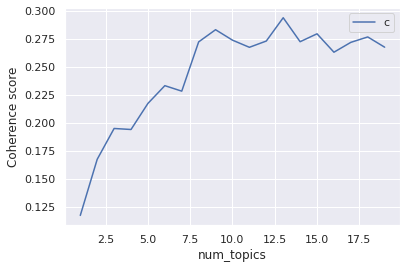

CPU times: user 32.3 s, sys: 3.18 s, total: 35.5 s
Wall time: 30.2 s


In [39]:
%%time
model_list, coherence_values = coherence_graph(dictionary=dictionary, corpus_tfidf=corpus_tfidf, data_reviews=data['review_body'].to_list(), limit=20, model= "lsi")


Según puede observarse en el gráfico, el mejor número de temas se encuentra en 13. A continuación se procede a listar los 13 temas ya con el modelo optimizado:

In [40]:
coherence_lsimodel = model_list[12]
word_dict = {};
for i in range(0,13):
    words = coherence_lsimodel.show_topic(i, topn = 15)
    word_dict['Topic# ' + '{:02d}'.format(i+1)] = [i[0] for i in words]
pd.DataFrame(word_dict)

,Topic# 01,Topic# 02,Topic# 03,Topic# 04,Topic# 05,Topic# 06,Topic# 07,Topic# 08,Topic# 09,Topic# 10,Topic# 11,Topic# 12,Topic# 13
0,bien,bien,producto,precio,producto,cumple,funciona,bastante,buena,perfecto,perfecto,llego,recomiendo
1,calidad,calidad,buen,buen,precio,precio,buen,buen,calidad,bastante,bastante,tiempo,solo
2,precio,buena,buena,calidad,buen,funciona,llego,buena,bastante,producto,solo,perfecto,compra
3,buena,precio,calidad,funciona,funciona,perfectamente,bastante,calidad,llego,buena,funciona,bastante,grande
4,producto,buen,bien,solo,calidad,solo,llegado,precio,funciona,buen,producto,solo,mal
5,bastante,producto,llego,recomiendo,bastante,buena,perfecto,producto,perfecto,calidad,uso,producto,llegado
6,buen,mala,llegado,llego,buena,mal,precio,perfecto,tiempo,llego,buen,buen,pequeño
7,funciona,mejor,tiempo,mala,cumple,recomiendo,calidad,llegado,mala,funciona,recomiendo,llegado,demasiado
8,cumple,compra,solo,bastante,solo,producto,perfectamente,mala,buen,tiempo,tiempo,mal,foto
9,recomiendo,cumple,cumple,perfecto,bien,buen,mal,grande,pequeño,solo,buena,recomiendo,calidad


**Conclusión:** El resultado muestra 13 temas dentro de los cuales prácticamente se registran las mismas palabras. Aunque cada una de las palabras en cada tema tiene pesos diferentes, el hecho de que las palabras se repitan de manera consistente entre uno y otro tema, no permite conceptualizar de manera diferencial e individual cada uno de ellos.

### **Modelo 3: Latent Dirichlet Allocation (LDA)**

LDA es un modelo que genera temas basados ​​en la frecuencia de palabras de un conjunto de documentos. En LDA el orden de las palabras no importa ya que sigue el concepto de una bolsa de palabras (lo cual resulta clave). 

A continuación se procede a entrenar el modelo LDA con 20 temas:


In [41]:
%%time
ldamodel = LdaModel(corpus_tfidf, num_topics=20, id2word=dictionary, minimum_probability=0.30)

CPU times: user 2.72 s, sys: 1.03 ms, total: 2.72 s
Wall time: 2.73 s


In [42]:
topics_lda = ldamodel.show_topics()
for topic in topics_lda:
    print(topic)

(6, '0.186*"gustado" + 0.113*"luz" + 0.078*"bastante" + 0.072*"vale" + 0.071*"marca" + 0.048*"espero" + 0.037*"puesto" + 0.029*"bien" + 0.016*"gusta" + 0.016*"buena"')
(12, '0.078*"bonito" + 0.068*"bonita" + 0.067*"genial" + 0.067*"perfecta" + 0.066*"encantado" + 0.055*"colores" + 0.051*"años" + 0.045*"nota" + 0.043*"mejor" + 0.039*"verdad"')
(16, '0.103*"tener" + 0.098*"pequeña" + 0.083*"caro" + 0.081*"tipo" + 0.073*"cuesta" + 0.047*"compra" + 0.033*"bien" + 0.026*"menos" + 0.023*"calidad" + 0.022*"bastante"')
(17, '0.200*"cumple" + 0.109*"pequeño" + 0.085*"correcto" + 0.068*"veces" + 0.059*"plastico" + 0.048*"bien" + 0.045*"ahora" + 0.041*"precio" + 0.031*"producto" + 0.026*"buen"')
(4, '0.124*"rapido" + 0.118*"llegado" + 0.116*"envio" + 0.078*"tamaño" + 0.063*"pone" + 0.041*"genial" + 0.036*"bien" + 0.035*"funciona" + 0.033*"normal" + 0.029*"buen"')
(19, '0.098*"momento" + 0.098*"mal" + 0.081*"fotos" + 0.075*"instrucciones" + 0.069*"agua" + 0.055*"hora" + 0.049*"deja" + 0.026*"bien"

In [43]:
word_dict = {};
for i in range(0,20):
    words = ldamodel.show_topic(i, topn = 15)
    word_dict['Topic# ' + '{:02d}'.format(i+1)] = [i[0] for i in words]
pd.DataFrame(word_dict)

,Topic# 01,Topic# 02,Topic# 03,Topic# 04,Topic# 05,Topic# 06,Topic# 07,Topic# 08,Topic# 09,Topic# 10,Topic# 11,Topic# 12,Topic# 13,Topic# 14,Topic# 15,Topic# 16,Topic# 17,Topic# 18,Topic# 19,Topic# 20
0,perfectamente,buena,llego,casa,rapido,bueno,gustado,perfecto,tiempo,color,bien,demasiado,bonito,facil,buen,foto,tener,cumple,viene,momento
1,recomiendo,calidad,entrega,duro,llegado,gusta,luz,regalo,comodo,estrellas,grande,sido,bonita,contenta,funciona,sirve,pequeña,pequeño,recomendable,mal
2,roto,precio,solo,hecho,envio,pequeños,bastante,libro,falta,ajusta,excelente,dinero,genial,buenos,sonido,contento,caro,correcto,gusto,fotos
3,funciona,gran,totalmente,material,tamaño,problemas,vale,poner,ver,pedi,resistente,pena,perfecta,practico,precio,recibido,tipo,veces,probado,instrucciones
4,casi,pedir,creo,llega,pone,talla,marca,compre,comprar,vendedor,siempre,mala,encantado,uso,producto,producto,cuesta,plastico,servicio,agua
5,cumple,comprado,producto,bien,genial,malo,espero,hacer,caso,meses,precio,igual,colores,dura,bien,carga,compra,bien,sale,hora
6,bien,bien,dentro,pena,bien,correctamente,puesto,usar,trae,poder,bastante,mes,años,usado,decir,llevar,bien,ahora,primera,deja
7,buena,semana,pedido,perfecto,funciona,original,bien,buen,bien,funcionar,calidad,compra,nota,parte,cristal,igual,menos,precio,calidad,bien
8,calidad,caja,bien,foto,normal,bien,gusta,reloj,devolver,bien,luego,calidad,mejor,usar,calidad,bien,calidad,producto,dia,producto
9,forma,mejor,paquete,compre,buen,precio,buena,precio,llego,uso,buena,bien,verdad,bien,buena,color,bastante,buen,llegar,pega


Se aplica la función de coherencia para revisar cuál es el número óptimo de temas para el modelo LDA.

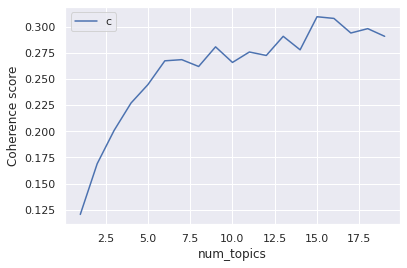

CPU times: user 1min 19s, sys: 92.8 ms, total: 1min 19s
Wall time: 1min 19s


In [44]:
%%time
model_list_LDA, coherence_values = coherence_graph(dictionary=dictionary, corpus_tfidf=corpus_tfidf, data_reviews=data['review_body'].to_list(), limit=20, model= "lda")

Según puede observarse en el gráfico, el mejor número de temas se encuentra en 15. A continuación se procede a listar los 15 temas ya con el modelo optimizado:

In [45]:
coherence_ldamodel = model_list_LDA[14]
word_dict = {};
for i in range(0,15):
    words = coherence_ldamodel.show_topic(i, topn = 15)
    word_dict['Topic# ' + '{:02d}'.format(i+1)] = [i[0] for i in words]
pd.DataFrame(word_dict)

,Topic# 01,Topic# 02,Topic# 03,Topic# 04,Topic# 05,Topic# 06,Topic# 07,Topic# 08,Topic# 09,Topic# 10,Topic# 11,Topic# 12,Topic# 13,Topic# 14,Topic# 15
0,grande,gustado,llego,buena,contento,mejor,genial,bueno,bien,gusta,pequeño,perfecto,producto,comodo,bonita
1,demasiado,rapido,pedir,calidad,funciona,mal,buen,meses,recomendable,gran,contenta,cumple,veces,excelente,tener
2,gusto,entrega,dinero,precio,falta,viene,facil,resistente,correcto,practico,perfecta,bastante,usado,perfectamente,llegado
3,solo,envio,nunca,encantado,pequeños,buenos,momento,tamaño,color,dura,poner,llevar,forma,luz,foto
4,problema,casa,sido,libro,diseño,sonido,usar,malo,fotos,bateria,casi,bien,servicio,colores,pone
5,hacer,comprar,tiempo,bien,sirve,calidad,regalo,original,uso,material,caro,recomiendo,deja,agua,comprado
6,instrucciones,roto,espero,bonito,bien,trae,siempre,bien,llega,reloj,ahora,tipo,buen,pega,plastico
7,bien,mes,decir,vale,ajusta,mala,caja,funciona,puesto,buen,primera,totalmente,poder,duro,normal
8,producto,ver,pedido,buen,cuesta,precio,lleva,funcionar,producto,problemas,bien,pequeña,semana,tiempo,bien
9,foto,caso,correctamente,pena,dia,bien,bien,hora,llegar,bien,compra,perfectamente,vendedor,marca,años


**Conclusión:** El resultado muestra 15 temas dentro de los cuales puede observarse una interesante y variada mezcla de palabras, las cuales definitivamente sí tienen mucha más consistencia con los aspectos que uno esperaría encontrar en una base de datos de reseñas u opiniones de clientes de Amazon. A partir de este resultado pueden ahora sí consolidarse las descripciones de los temas que agrupen las palabras más representativas, consistentes y relacionadas por grupo.

## **4. Visualización del Modelo Final y Conclusiones**

1. Tanto el Modelo 1 como el Modelo 2 arrojaron resultados que no permitían hacer una adecuada interpretación de los temas según las palabras y que fueran acordes con la lógica de los que se esperaría del análisis de reseñas u opiniones de los usuarios de Amazon, razón por la cual estos modelos deben desecharse.

2. El Modelo 3 (LDA) arrojó un resultado óptimo en cuanto a la variedad y consistencia de las palabras utilizadas en las reseñas u opiniones, las cuales permitieron agrupar de manera lógica dichas reseñas, tal y como se muestran a continuación los temas con algunas de sus palabras asociadas:

  * Topic 1: Tamaño de los productos (Grande, Demasiado, Tamaño, Pequeña)

  * Topic 2: Logística y Despacho de los productos (Rápido, Entrega, Envío, Paquete, Recibido)

  * Topic 3: Tiempo de entrega de los productos (Llegó, Pedir, Nunca, Tiempo, Espero)

  * Topic 4: Percepción de la relación calidad vs precio de los productos (Buena, Calidad, Precio, Encantado, Buen) 

  * Topic 5: Funcionamiento de los productos (Funciona, Falta, Diseño, Sirve, Ajusta)

  * Topic 6: Calidad de los productos (Mejor, Mal, Buenos, Calidad, Mala)

  * Topic 7: Facilidad de uso de los productos (Buen, Fácil, Usar, Probado, Producto)

  * Topic 8: Resistencia de los productos (Bueno, Meses, Resistente, Original, Funciona)

  * Topic 9: Recomendaciones del producto a otros clientes (Bien, Recomendable, Correcto, Uso, Llega)

  * Topic 10: Duración de los productos en el tiempo (Dura, Batería, Material, Buen, Años)

  * Topic 11: Percepción de valor del producto (Pequeño, Perfecta, Caro, Tamaño)

  * Topic 12: Cubrimiento de expectativas generales del cliente (Perfecto, Cumple, Recomiendo, Totalmente, Perfectamente)

  * Topic 13: Servicio ofrecido por el vendedor (Producto, Servicio, Buen, Vendedor, Veces)

  * Topic 14: Características de los productos (Luz, Colores, Agua, Pega, Dura)

  * Topic 15: Satisfacción generald del cliente (Bonita, Foto, Llegado, normal bien)
  

3. Utilizando la librería PyLDAvis se puede hacer una visualización interactiva para ayudarnos a interpretar los temas del modelo seleccionado (LDA). A partir de esta visualización podemos también sacar las siguientes conclusiones: 

 * Existen algunas palabras dentro de las reseñas que aplican para varios de los temas o tópicos, por ejemplo, los topicos 5, 9 y 11 tienen palabras fuertemente relacionadas, tal y como se observa en la gráfica.

 * El gráfico también permite observar las 30 palabras que más se utilizan en los 15 temas, por ejemplo la palabra "bien" es la de mayor frecuencia. 

 * Al seleccionar cada tema se muestra en color rojo la frecuencia estimada de la palabra dentro de cada topico, por ejemplo, la palabra "grande" es la que en promedio aparece más en el tópico 1. 

4. A partir de la experiencia en el desarrollo de este trabajo se pudo observar que un buen pre-procesamiento de los datos es determinante en el resultado de los modelos, en lo que se refiere a la mezcla resultante de las palabras por tópico, es decir, en cuanto a si los grupos de palabras son coherentes y lógicos para lo que se espera según el dataset que se tiene y el conocimiento del mismo, por ende, se hace necesario que se dedique buen tiempo al pre-procesamiento y a correr los modelos con diferentes combinaciones de parámetros hasta encontrar el resultado que mejor se ajuste según nuestra experiencia con los datos y más allá de los resultados de la métrica, esto porque se pudo observar que no necesariamente los resultados de una métrica alta o favorable son los correctos en lo que respecta a la lógica y tampoco significa que el modelo pueda generalizar de manera precisa frente a datos nuevos. 

5. A futuro se puede realizar otras pruebas y correr este mismo proyecto haciendo uso de otras librerías especializadas en el modelamiento de temas para probar si mejora el resultado en cuanto a la coherencia de los temas agrupados. Por ejemplo, se puede hacer uso de la librería [tomotopy](https://pypi.org/project/tomotopy/) (Topic Modeling Tool), la cual soporta varios modelos como los que se utilizaron en este proyecto.  


In [46]:
import pyLDAvis
import pyLDAvis.gensim

lda_display = pyLDAvis.gensim.prepare(coherence_ldamodel, corpus_tfidf, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

/usr/local/lib/python3.7/dist-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping
